In [39]:
!pip install geopy
!pip install catboost
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.9 MB/s eta 0:00:009.3 MB/s eta 0:00:01


# Import data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
# Load CSV dataset
df=pd.read_csv("HousePriceDataset.csv")
print(f"Number of houses in dataset: {len(df)}")
print(f"Number of variables in dataset: {len(df.columns)}")
df=df.drop(columns=['Unnamed: 0'])

# Display the column names (features) in the dataset
print(f"Features in the dataset: {list(df.columns)}")

# Display basic statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values in the dataset
print("\nMissing Values:")
print(df.isnull().sum())

# Display data types of each column
print("\nData Types:")
print(df.dtypes)

Number of houses in dataset: 21613
Number of variables in dataset: 21
Features in the dataset: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Summary Statistics:
                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.90000

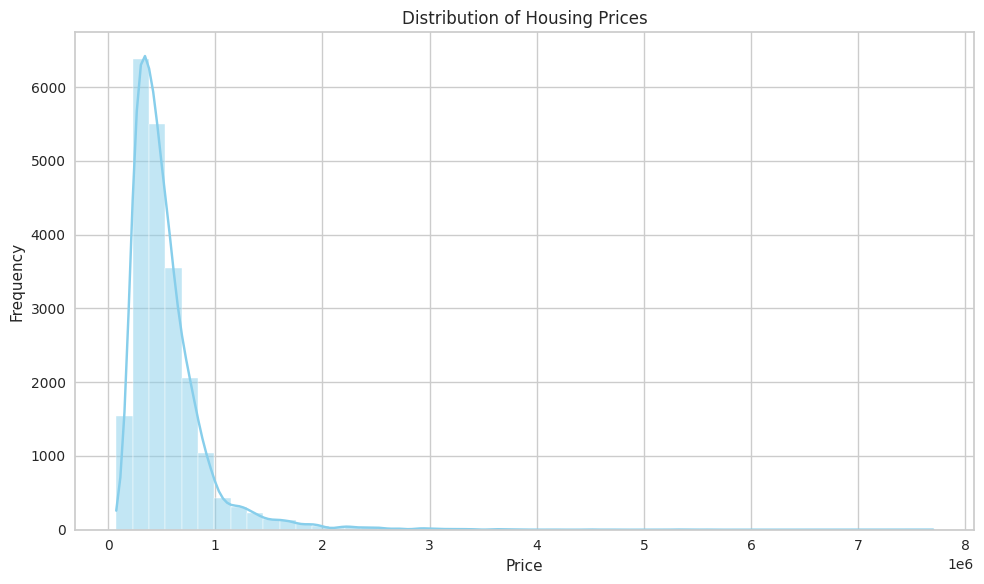

In [79]:
sns.set_style("whitegrid")

# Creating the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50, color='skyblue')

# Setting the title and labels
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()

# Display the plot
plt.show()

100%|███████████████████████████████████████████| 98/98 [00:18<00:00,  5.37it/s]


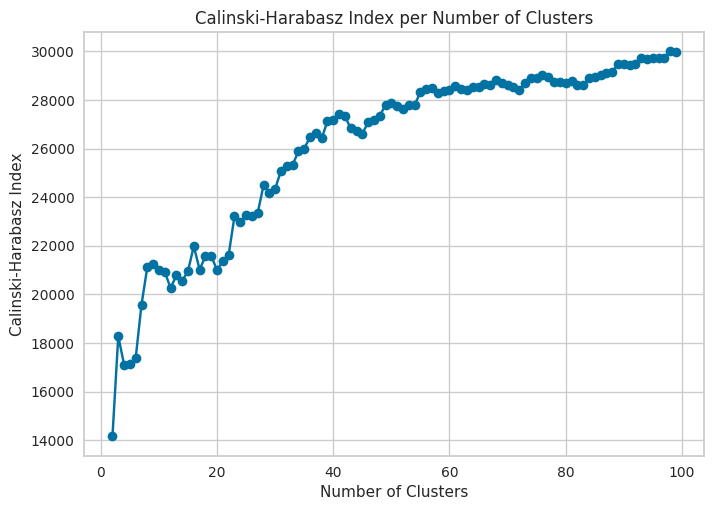

In [80]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt
from tqdm import tqdm

coords = df[['lat', 'long']]

# Calculate Calinski-Harabasz index for different numbers of clusters
calinski_harabasz_values = []

# Try many clusters as we scan a large area
n_clusters_range = range(2, 100)
for n_clusters in tqdm(n_clusters_range):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(coords)
    calinski_harabasz_values.append(calinski_harabasz_score(coords, labels))

# Plot the Calinski-Harabasz index scores
plt.plot(n_clusters_range, calinski_harabasz_values, marker='o')
plt.title('Calinski-Harabasz Index per Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()

Optimal number of clusters: 98


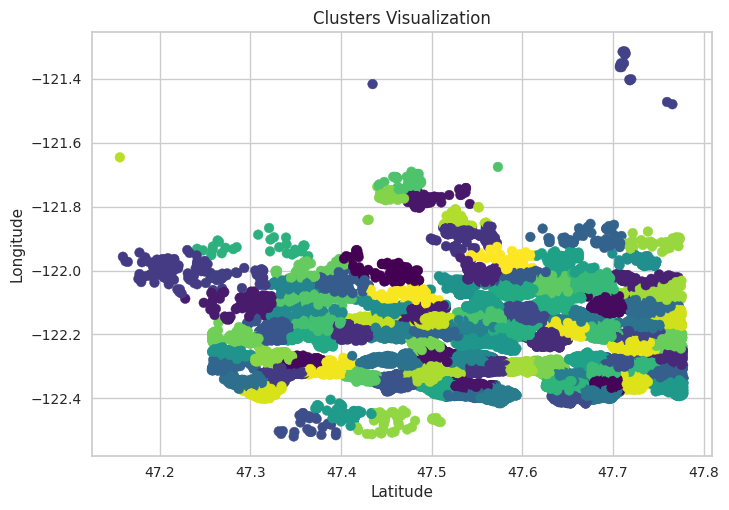

In [81]:
optimal_clusters = n_clusters_range[calinski_harabasz_values.index(max(calinski_harabasz_values))]
print(f"Optimal number of clusters: {optimal_clusters}")

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(coords)

df['Cluster'] = clusters
plt.scatter(df['lat'], df['long'], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Clusters Visualization')
plt.show()

# Calculate and map average price for each cluster
avg_prices = df.groupby('Cluster')['price'].mean().to_dict()
df['Avg_Cluster_Price'] = df['Cluster'].map(avg_prices)

In [82]:
import pandas as pd
from geopy.geocoders import Nominatim
from collections import defaultdict

geolocator = Nominatim(user_agent="geoapiExercises")

# Function to get location details using latitude and longitude
def get_location_details(lat, lon):
    location = geolocator.reverse((lat, lon))
    if location:
        return location.address
    else:
        return 'Not found'

unique_coords = df[['lat', 'long']]
coords_info = defaultdict(str)

# Convert the dictionary to a DataFrame for easier viewing
coords_info_df = pd.DataFrame(list(coords_info.items()), columns=['Coordinates', 'Address'])

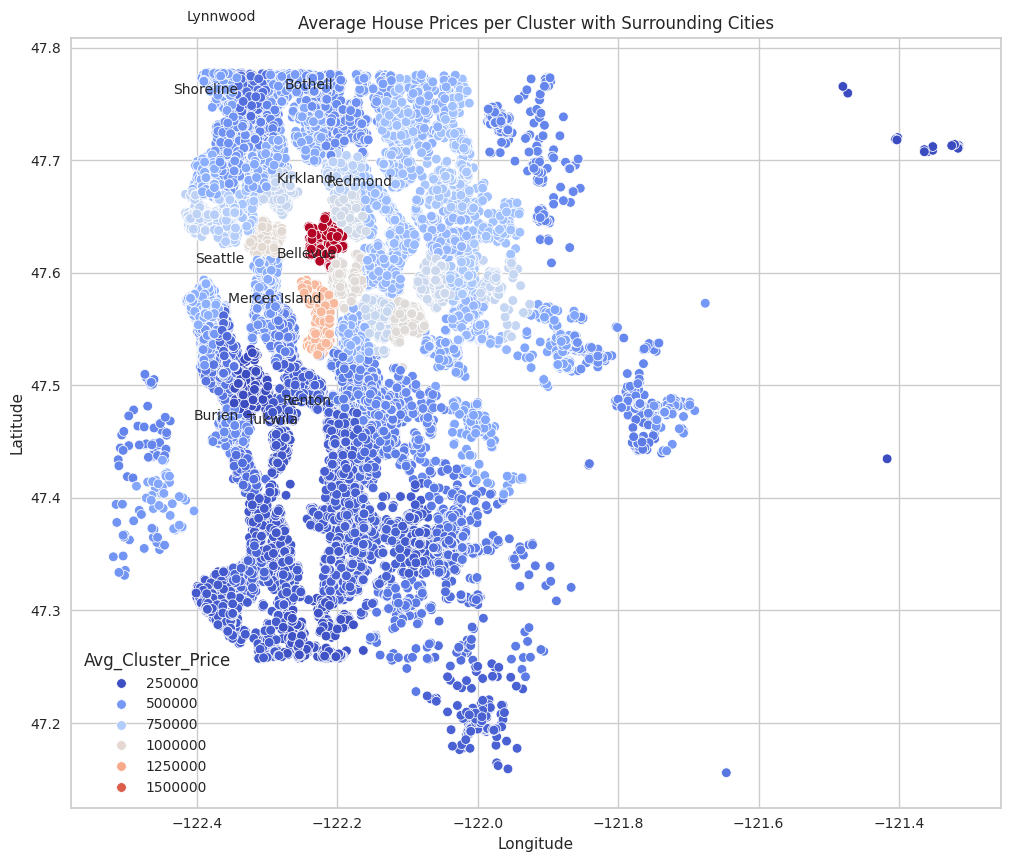

In [83]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
cities = {
    "Seattle": (47.6062, -122.3321),
    "Bellevue": (47.6101, -122.2015),
    "Kirkland": (47.6769, -122.2060),
    "Redmond": (47.6740, -122.1215),
    "Renton": (47.4797, -122.2079),
    "Shoreline": (47.7557, -122.3415),
    "Burien": (47.4668, -122.3405),
    "Tukwila": (47.4627, -122.2559),
    "Mercer Island": (47.5707, -122.2221),
    "Lynnwood": (47.8209, -122.3151),
    "Bothell": (47.7601, -122.2054)
}

# Create a scatter plot with heatmap
plt.figure(figsize=(12, 10))
sns.scatterplot(data=df, x='long', y='lat', hue='Avg_Cluster_Price',
                sizes=(20, 200), palette='coolwarm')

# Plot each city and add the city name
for city, (lat, lon) in cities.items():
    plt.text(lon, lat, city, fontsize=10, ha='right', va='bottom')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Average House Prices per Cluster with Surrounding Cities')
plt.show()


In [84]:
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
import numpy as np

In [85]:
### Clean the data  'sqft_lot15'
def clean_data(value):
    if isinstance(value, str) and value.startswith("b'"):
        return float(value[2:-1])
    return float(value)

df['sqft_lot15'] = df['sqft_lot15'].apply(clean_data)

# Supervised learning

## Linear-regression

In [86]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline



# Assuming the target variable is 'Price' and the rest are features
X = df.drop('price', axis=1)  # Replace 'Price' with your actual target column name
y = df['price']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models
models = {
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "Linear Regression": LinearRegression()
}

# Perform cross-validation
for name, model in models.items():
    # Create a pipeline for scaling and regression
    pipeline = make_pipeline(StandardScaler(), model)
    
    # Perform cross-validation and compute mean score
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')  # cv is the number of folds
    print(f"{name} model, Mean R^2 Score: {scores.mean():.4f}")

Lasso model, Mean R^2 Score: 0.7863
Ridge model, Mean R^2 Score: 0.7863
Linear Regression model, Mean R^2 Score: 0.7863


In [87]:
import warnings
warnings.filterwarnings('ignore')


# adjust alpha
alphas = [0.0001, 0.001, 0.01, 0.1, 1.0, 2.0]
for alpha in alphas:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    # Lasso Regression with K-Fold Cross Validation
    print("---------------LASSO-------------------")
    lasso_model = Lasso(alpha=alpha, max_iter=1000)
    lasso_scores = cross_val_score(lasso_model, X_train, y_train, cv=kf)
    print("Cross-Validation Scores:", lasso_scores)
    print("Mean CV Score:", np.mean(lasso_scores))

    for feature, coef in zip(X.columns, coefficients):
        print('feature:', feature, 'coefficient:', coef)
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"alpha={alpha}，cross valitation MSE: {-cv_scores.mean()}")

---------------LASSO-------------------


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py", line 905, in fit
    X, y = self._validate_data(
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/base.py", line 622, in _validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1162, in check_X_y
    y = _check_y(y, multi_output=multi_output, y_numeric=y_numeric, estimator=estimator)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leonardomonchieri/miniconda3/lib/python3.11/site-packages/sklearn/utils/validation.py", line 1187, in _check_y
    y = y.astype(np.float64)
        ^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'Low (200k-400k)'


In [ ]:
model = RandomForestRegressor()
cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print(f"model={model}，cross valitation MSE: {-cv_scores.mean()}")

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
# Load CSV dataset
#df=pd.read_csv("/content/HousePriceDataset (1).csv")
#df=pd.read_csv("/content/drive/MyDrive/data/machine_learning/HousePriceDataset.csv")
# Load CSV in YW
df=pd.read_csv("HousePriceDataset.csv")
print(f"Number of houses in dataset: {len(df)}")
print(f"Number of variables in dataset: {len(df.columns)}")
df=df.drop(columns=['Unnamed: 0'])
# Display the column names (features) in the dataset
print(f"Features in the dataset: {list(df.columns)}")

# Display basic statistics for numerical columns
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values in the dataset
print("\nMissing Values:")
print(df.isnull().sum())

# Display data types of each column
print("\nData Types:")
print(df.dtypes)

Number of houses in dataset: 21613
Number of variables in dataset: 21
Features in the dataset: ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

Summary Statistics:
                 id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.90000

## Classification

### Class splittig

<Figure size 1200x700 with 0 Axes>

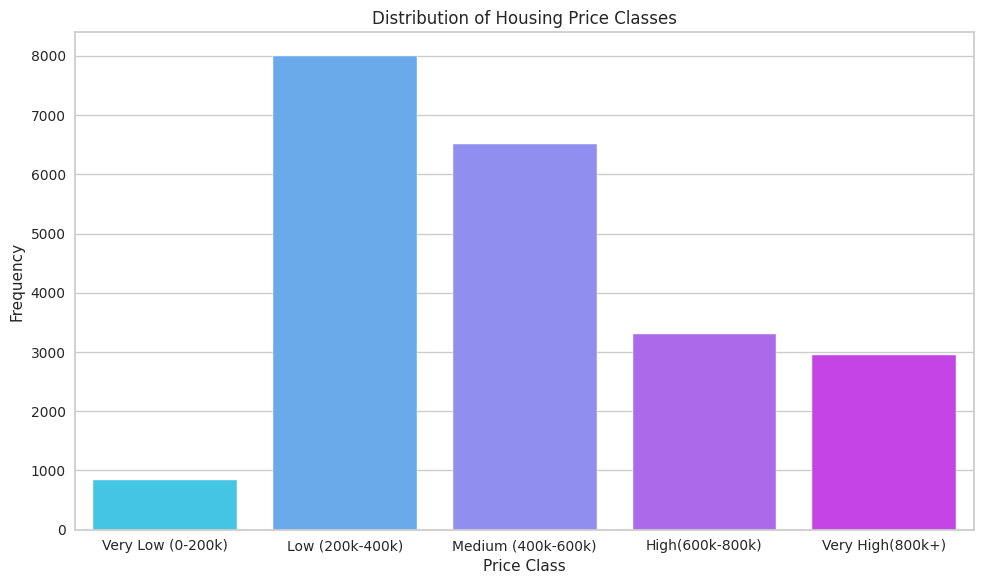

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

price_bins = [0, 200000, 400000, 600000, 800000, np.inf]
price_labels = ['Very Low (0-200k)', 'Low (200k-400k)', 'Medium (400k-600k)', 'High(600k-800k)', 'Very High(800k+)']

# Assign Classes
df['price_class'] = pd.cut(df['price'], bins=price_bins, labels=price_labels)
plt.figure(figsize=(12, 7))

plt.figure(figsize=(10, 6))
sns.countplot(x='price_class', data=df, palette='cool', hue='price_class', legend=False)
plt.title('Distribution of Housing Price Classes')
plt.xlabel('Price Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Classification models

 Remove least 5 variables for complexity

In [88]:
### Clean the data 
df_np = df.drop(["sqft_lot","long","condition","yr_renovated","floors","id","Cluster","price","lat","zipcode"],axis=1)
df_x = df_np.drop(['price_class'],axis=1)
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_x), columns=df_x.columns)

X = df_normalized
y = df_np['price_class']

KeyError: "['price_class'] not found in axis"

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

# For One-vs-All
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

ovo_model = OneVsOneClassifier(LogisticRegression(max_iter=1000),n_jobs=-1)  # Increased max_iter for convergence
ovo_model.fit(X_train, y_train)

# One-vs-All Logistic Regression
ova_model = OneVsRestClassifier(LogisticRegression(max_iter=1000), n_jobs=-1)  # Increased max_iter for convergence
ova_model.fit(X_train, y_train)
# One-vs-One Logistic Regression

# Save the One-vs-One model
with open('ovo_model.pkl', 'wb') as file:
    pickle.dump(ovo_model, file)

# Save the One-vs-All model
with open('ova_model.pkl', 'wb') as file:
    pickle.dump(ova_model, file)

In [ ]:
y_pred_ova = ova_model.predict(X_test)
y_pred_ovo = ovo_model.predict(X_test)

print("One-vs-All Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_ova))
print(classification_report(y_test, y_pred_ova, zero_division = 0.0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ova))

# Predictions and Performance Evaluation for One-vs-One
y_pred_ovo = ovo_model.predict(X_test)
print("\nOne-vs-One Performance:")

print("Accuracy:", accuracy_score(y_test, y_pred_ovo))
print(classification_report(y_test, y_pred_ovo, zero_division = 0.0))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ovo))

## Boosting

### Visualisation functions

In [9]:
def plotCrossValidationEstimators(train_score_models, test_score_models, cv_scores, title):
  train_colors_set = ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple', 'tab:pink']
  test_colors_set = ['skyblue', 'lightgreen', 'wheat', 'lightsalmon', 'plum', 'pink']

  cv = len(train_score_models[0])

  fig, axes = plt.subplots(1, len(train_score_models), figsize=(20, 5), sharey=True)

  for i, n_estimator in enumerate(n_estimators_list):

    #Plot train scores
    axes[i].plot(range(cv), train_score_models[i] , marker='o', label=f'Train({n_estimator} estimators)', color=train_colors_set[i])

    # Plot test scores
    axes[i].plot(range(cv), test_score_models[i], marker='o', linestyle='-', label=f'Test ({n_estimator} estimators)', color=test_colors_set[i])

    # Add cross-validation score text
    axes[i].text(0.5, -0.2, f'Mean Cross Validation Score: {cv_scores[i]:.2f}', transform=axes[i].transAxes, ha='center')


    axes[i].set_title(f'{n_estimator} Estimators')
    axes[i].set_xlabel('Fold')
    axes[i].set_ylabel('Score')
    axes[i].legend()

  plt.suptitle(title+' Cross-Validation Results for Different Numbers of Estimators', y=1.0)
  plt.tight_layout()
  plt.show()

### One vs One model

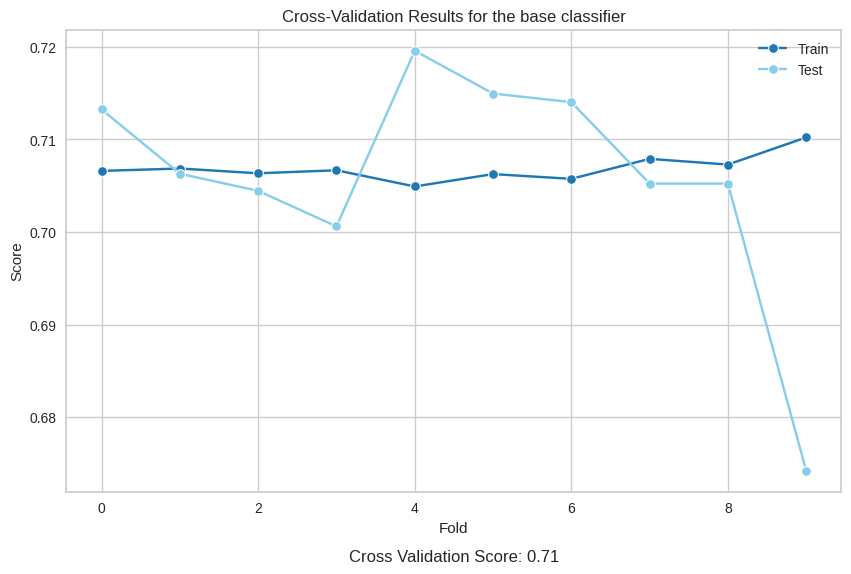

In [10]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

scores = cross_validate(ovo_model, X, y, cv=10, return_train_score=True);
score = cross_val_score(ovo_model, X, y, cv=10)
mean_score = score.mean()

# Plot the results using a line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(10), y=scores['train_score'], marker='o', linestyle='-', label='Train', color ='tab:blue')
sns.lineplot(x=range(10), y=scores['test_score'], marker='o', linestyle='-', label='Test', color ='skyblue')
plt.title('Cross-Validation Results for the base classifier')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.text(0.5, -0.15, f'Cross Validation Score: {mean_score:.2f}', ha='center', transform=plt.gca().transAxes)
plt.legend()
plt.show()

### AdaBoosting

In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [12]:
base_estimators = [
    ('Decision Stump', DecisionTreeClassifier(max_depth=1)),
    ('Logistic Regression', LogisticRegression()),
    ('Naive Bayes', GaussianNB()),
    ('Linear SVM', SVC(kernel='linear')), #The SVM approach can take more then 20 minutes to fully run al the folds.
]

X_train_estimators, _ , y_train_estimators, _ = train_test_split(X, y, test_size=0.7, random_state=42)

for name, base_estimator in tqdm(base_estimators):
  ada_boost_classifier = AdaBoostClassifier(base_estimator, n_estimators=50,learning_rate=0.1, random_state=45, algorithm ='SAMME')
  ada_boost_classifier_ovo = OneVsOneClassifier(ada_boost_classifier)
  scores = cross_val_score(ada_boost_classifier, X_train_estimators, y_train_estimators, cv=5)
  print(f'{name} - Mean Cross-Validation Accuracy: {scores.mean():.3f}')


 25%|███████████▎                                 | 1/4 [00:02<00:07,  2.40s/it]

Decision Stump - Mean Cross-Validation Accuracy: 0.572


 50%|██████████████████████▌                      | 2/4 [00:21<00:23, 11.97s/it]

Logistic Regression - Mean Cross-Validation Accuracy: 0.484


 75%|█████████████████████████████████▊           | 3/4 [00:24<00:07,  7.88s/it]

Naive Bayes - Mean Cross-Validation Accuracy: 0.378


100%|████████████████████████████████████████████| 4/4 [11:01<00:00, 165.49s/it]

Linear SVM - Mean Cross-Validation Accuracy: 0.367


In [13]:
n_estimators_list = [25, 50, 100, 200, 400]


train_score_models = []
test_score_models  = []
overall_score = []


for n in tqdm(n_estimators_list, desc="Training Adaboost Models"):
  base_classifier = DecisionTreeClassifier(max_depth=1)
  ada_boost = AdaBoostClassifier(base_classifier,n_estimators = n, learning_rate=0.3, random_state=45)
  ovo_ada_boost = OneVsOneClassifier(ada_boost)
    
  scores = cross_validate(ovo_ada_boost, X, y, cv=10, return_train_score=True);
  score = cross_val_score(ovo_ada_boost, X, y, cv=10)

  overall_score.append(score.mean())
  train_score_models.append(scores['train_score'])
  test_score_models.append(scores['test_score'])


Training Adaboost Models:  80%|██████████████▍   | 4/5 [15:07<03:46, 226.83s/it]


KeyboardInterrupt: 

In [ ]:
plotCrossValidationEstimators(train_score_models, test_score_models,overall_score, 'Adaboosting')

In [ ]:
ovo_ada_boost.fit(X_train, y_train)
y_pred = ovo_ada_boost.predict(X_test)

print("---AdaBoost(400 estimators)---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

### XGBoosting

In [ ]:
import xgboost as xgb

In [ ]:
#One vs One
n_estimators_list = [25, 50, 100, 200]

train_score_models = []
test_score_models  = []
overall_score = []

for n in tqdm(n_estimators_list):
  xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=5, n_estimators=n, learning_rate=0.1)
  ovo_xgb_classifier = OneVsOneClassifier(xgb_classifier)

  scores = cross_validate(ovo_xgb_classifier, X, y, cv=10, return_train_score=True);

  overall_score.append(score.mean())
  train_score_models.append(scores['train_score'])
  test_score_models.append(scores['test_score'])

In [ ]:
plotCrossValidationEstimators(train_score_models, test_score_models, overall_score, 'xGboosting')

In [ ]:
ovo_xgb_classifier.fit(X_train, y_train)
y_pred = ovo_xgb_classifier.predict(X_test)

print("---XGBoost(100 estimators)---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

## Fine-tuning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import math
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

df_x=df.drop(["sqft_lot","condition","yr_renovated","floors","price","id","zipcode"],axis=1)

#If clustering and classification is done
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_x), columns=df_x.columns)

X = df_normalized
y = df['price']
# For One-vs-All
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train KMeans on coordinates from X_train
coords_train = X_train[['lat', 'long']]
kmeans = KMeans(n_clusters=95, random_state=42)
kmeans.fit(coords_train)

# Assign clusters to X_train
X_train['Cluster'] = kmeans.predict(coords_train)

# Drop 'long' and 'lat' from X_train
X_train = X_train.drop(['long', 'lat'], axis=1)

# Correcting the code to drop 'long' and 'lat' from X_test
coords_test = X_test[['lat', 'long']]  # Keep the coordinates for cluster prediction
X_test = X_test.drop(['long', 'lat'], axis=1)

# Assign clusters to X_test based on the nearest cluster center
X_test['Cluster'] = kmeans.predict(coords_test)
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'LogisticRegression': LogisticRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR()
}

# Function to train and evaluate models
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - RMSE: {math.sqrt(mse):.2f}, R^2: {r2:.2f}")
train_and_evaluate(models, X_train, y_train, X_test, y_test)
models = {
    # Adding advanced boosting models
    'XGBRegressor': XGBRegressor(n_estimators=100, random_state=42),
    'LGBMRegressor': LGBMRegressor(n_estimators=100, random_state=42, force_row_wise=True),
    'CatBoostRegressor': CatBoostRegressor(iterations=100, random_seed=42, silent=True)  # silent=True for less verbosity
}
# Function to train and evaluate models
def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        print(f"{name} - RMSE: {math.sqrt(mse):.2f}, R^2: {r2:.2f}")
train_and_evaluate(models, X_train, y_train, X_test, y_test)

LinearRegression - RMSE: 182199.78, R^2: 0.78


In [ ]:
model_1= XGBRegressor(n_estimators=100, random_state=42)

model_1.fit(X_train, y_train)
y_pred = model_1.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"GBR - RMSE: {math.sqrt(mse):.2f}, R^2: {r2:.2f}")

In [92]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

df_x=df.drop(["sqft_lot","condition","yr_renovated","floors","price","id","zipcode"],axis=1)

min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_x), columns=df_x.columns)
X = df_normalized.values  # Convert to NumPy array for indexing flexibility
y = df['price'].values

# Define the number of splits for CV
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Parameter grid

best_score = float('inf')
best_params = None
# Define your param_grid with the relevant XGBoost parameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

# Loop through each combination of parameters
for n_estimators in param_grid['n_estimators']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            for min_child_weight in param_grid['min_child_weight']:
                for gamma in param_grid['gamma']:

                    cv_scores = []

                    for train_index, val_index in kf.split(X):
                        # Splitting the data into train and validation sets
                        X_train, X_val = X[train_index], X[val_index]
                        y_train, y_val = y[train_index], y[val_index]

                        # Perform KMeans clustering on the training set
                        kmeans = KMeans(n_clusters=95, random_state=42, n_init='auto')
                        kmeans.fit(X_train[:, :2])  # Adjust as needed

                        # Assign clusters to training and validation sets
                        X_train_clustered = np.c_[X_train, kmeans.predict(X_train[:, :2])]
                        X_val_clustered = np.c_[X_val, kmeans.predict(X_val[:, :2])]

                        # Train the model with the current set of parameters
                        model = XGBRegressor(
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            min_child_weight=min_child_weight,
                            gamma=gamma
                        )
                        model.fit(X_train_clustered, y_train)

                        # Evaluate the model
                        predictions = model.predict(X_val_clustered)
                        score = mean_squared_error(y_val, predictions, squared=False)  # RMSE
                        cv_scores.append(score)

                    # Compute average score over all CV folds
                    avg_score = np.mean(cv_scores)

                    # Update best score and parameters
                    if avg_score < best_score:
                        best_score = avg_score
                        best_params = {
                            'n_estimators': n_estimators,
                            'learning_rate': learning_rate,
                            'max_depth': max_depth,
                            'min_child_weight': min_child_weight,
                            'gamma': gamma
                        }

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_score}")

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error

X = df_normalized
y = df['price']

# Define a scorer, if you want to use RMSE instead of the default R^2 score
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set the parameters you want to tune
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 4, 6],
}

# Initialize the Gradient Boosting Regressor
gb = XGBRegressor()

# Initialize the Grid Search Model
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring=scorer)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters set found on development set:")
print(grid_search.best_params_)
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# You might want to get the RMSE, since mean_squared_error is negative in the grid search
best_rmse = mean_squared_error(y, grid_search.best_estimator_.predict(X), squared=False)
best_r2_cv = grid_search.best_score_
print(f"Best cross-validated R^2 score: {best_r2_cv}")
print(f"Best RMSE: {best_rmse}")


In [ ]:
### Clean the data  'sqft_lot15'
def clean_data(value):
    if isinstance(value, str) and value.startswith("b'"):
        return float(value[2:-1])
    return float(value)

df_x=df.drop(["sqft_lot","condition","yr_renovated","floors","price","id","zipcode"],axis=1)

#If clustering and classification is done
#df_x=df.drop(["sqft_lot","condition","yr_renovated","floors","Cluster","price_class","price","id","zipcode"],axis=1)
min_max_scaler = MinMaxScaler()
df_normalized = pd.DataFrame(min_max_scaler.fit_transform(df_x), columns=df_x.columns)

X = df_normalized
y = df['price']

# For One-vs-All
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train KMeans on coordinates from X_train
coords_train = X_train[['lat', 'long']]
kmeans = KMeans(n_clusters=95, random_state=42, n_init ='auto')
kmeans.fit(coords_train)

# Assign clusters to X_train
X_train['Cluster'] = kmeans.predict(coords_train)

# Drop 'long' and 'lat' from X_train
X_train = X_train.drop(['long', 'lat'], axis=1)

# Correcting the code to drop 'long' and 'lat' from X_test
coords_test = X_test[['lat', 'long']]  # Keep the coordinates for cluster prediction
X_test = X_test.drop(['long', 'lat'], axis=1)

# Assign clusters to X_test based on the nearest cluster center
X_test['Cluster'] = kmeans.predict(coords_test)
model = XGBRegressor(n_estimators=300, learning_rate =0.2, max_depth= 5, min_child_weight= 1, gamma =0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
best_r2_alternative = r2_score(y_test, predictions)
print(f"Best R^2 (alternative method): {best_r2_alternative}")

In [ ]:
y_pred = grid_search.best_estimator_.predict(X_train)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"GBR - RMSE: {math.sqrt(mse):.2f}, R^2: {r2:.2f}")

In [ ]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import make_scorer, mean_squared_error

X = df_normalized
y = df['price']

# Define a scorer, if you want to use RMSE instead of the default R^2 score
scorer = 'r2'

# Set the parameters you want to tune
param_grid = {
    'n_estimators': [500,750,1000],
    'learning_rate': [0.1],
    'max_depth': [4],
    'min_samples_leaf': [3],
    'min_samples_split': [2],
}

# Initialize the Gradient Boosting Regressor
gb = GradientBoostingRegressor()

# Initialize the Grid Search Model
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, scoring=scorer)

# Fit the grid search to the data
grid_search.fit(X, y)

# Print the best parameters and the corresponding score
print("Best parameters set found on development set:")
print(grid_search.best_params_)
print("Grid scores on development set:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

# You might want to get the RMSE, since mean_squared_error is negative in the grid search
best_rmse = mean_squared_error(y, grid_search.best_estimator_.predict(X), squared=False)
best_r2_cv = grid_search.best_score_
print(f"Best cross-validated R^2 score: {best_r2_cv}")
print(f"Best RMSE: {best_rmse}")

In [ ]:
predictions = grid_search.best_estimator_.predict(X)
best_r2_alternative = r2_score(y, predictions)
print(f"Best R^2 (alternative method): {best_r2_alternative}")

# Unsupervised learning

In [8]:
import numpy as np

## Data pre-processing
X is the data we want to use in dimensionality reduction and clustering

In [9]:
### Clean the data  'sqft_lot15'
def clean_data(value):
    if isinstance(value, str) and value.startswith("b'"):
        return float(value[2:-1])
    return float(value)

df['sqft_lot15'] = df['sqft_lot15'].apply(clean_data)
X = df.drop(['price','id'], axis=1)
y = df['price']

## Dimensionality reduction

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split


### Data standardization

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## First reduction then clustering

PCA, AutoEncoder & T-SNE

In [29]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# tsne = TSNE(n_components=2)
tsne = TSNE(n_components=2, init='random', learning_rate=200.0)
X_tsne = tsne.fit_transform(X_scaled)

In [30]:
# Split the data as training data and test data
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

input_dim = X_train.shape[1]  # Current dimensionality
encoding_dim = 2  # reduce to 2

# encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# decoder
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# autoencoder
autoencoder = Model(input_layer, decoded)

# model compile
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# training
autoencoder.fit(X_train, X_train, epochs=50, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

# builde the encoder
encoder = Model(input_layer, encoded)

# reduce the dimension
X_ae = encoder.predict(X_scaled)

Epoch 1/50
68/68 [==============================] - 0s 2ms/step - loss: 1.2228 - val_loss: 1.2634
Epoch 2/50
68/68 [==============================] - 0s 1ms/step - loss: 1.1877 - val_loss: 1.2283
Epoch 3/50
68/68 [==============================] - 0s 1ms/step - loss: 1.1529 - val_loss: 1.1947
Epoch 4/50
68/68 [==============================] - 0s 1ms/step - loss: 1.1208 - val_loss: 1.1657
Epoch 5/50
68/68 [==============================] - 0s 1ms/step - loss: 1.0923 - val_loss: 1.1396
Epoch 6/50
68/68 [==============================] - 0s 1ms/step - loss: 1.0657 - val_loss: 1.1148
Epoch 7/50
68/68 [==============================] - 0s 1ms/step - loss: 1.0397 - val_loss: 1.0899
Epoch 8/50
68/68 [==============================] - 0s 1ms/step - loss: 1.0124 - val_loss: 1.0617
Epoch 9/50
68/68 [==============================] - 0s 1ms/step - loss: 0.9810 - val_loss: 1.0280
Epoch 10/50
68/68 [==============================] - 0s 1ms/step - loss: 0.9453 - val_loss: 0.9920
Epoch 11/50
68/68 [

## Color by labels

In [31]:

y = df['price']

# Define the threshold
bins = [0, 200000, 400000, 600000, 800000, np.inf]
price_bins = pd.cut(y, bins, right=False, labels=False)

# assign colors to price range
colors = ['blue', 'green', 'yellow', 'orange', 'red']

def visualize_clusters_with_price(X, title):
    plt.figure(figsize=(8, 6))

    # draw the data points
    for i in range(len(bins) - 1):
        mask = price_bins == i
        plt.scatter(X[mask, 0], X[mask, 1], color=colors[i], s=25, label=f'{bins[i]}-{bins[i+1]}k')

    plt.title(title)
    plt.legend()
    plt.show()

In [32]:
reduced_data = {
    'pca': X_pca,
    'tsne': X_tsne,
    'ae': X_ae
}

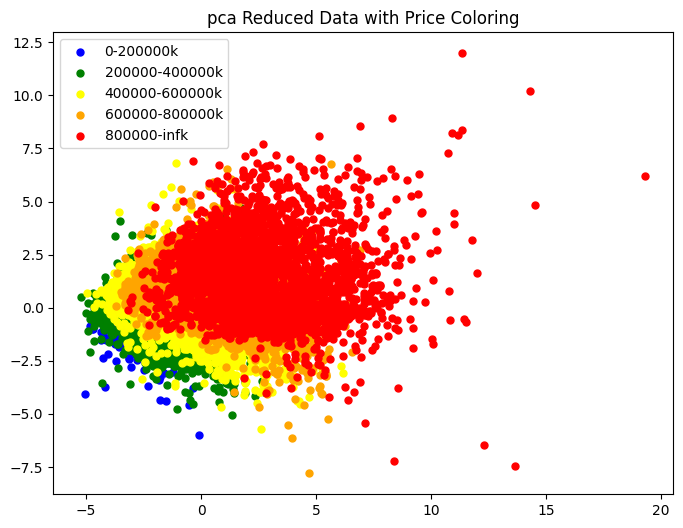

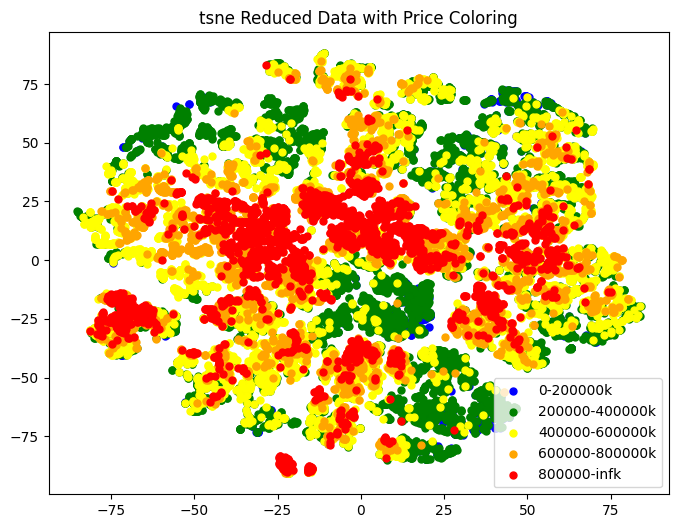

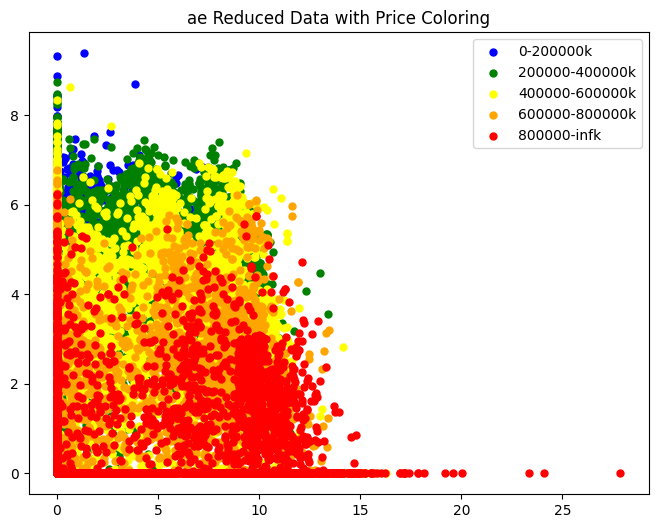

In [33]:
for key,values in reduced_data.items():
    name = key
    X = values
    visualize_clusters_with_price(X, f'{name} Reduced Data with Price Coloring')

## Clustering

### K-means

In [34]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
# clustering on original dataset
kmeans_orig = KMeans(n_clusters=5, random_state=42)
k_clusters_orig = kmeans_orig.fit_predict(X_scaled)

# clustering on reduced dataset by pca
kmeans_pca = KMeans(n_clusters=5, random_state=42)
clusters_pca = kmeans_pca.fit_predict(X_pca)
# Tsne
# clustering on reduced dataset by pca
kmeans_tsne = KMeans(n_clusters=5, random_state=42)
clusters_tsne = kmeans_tsne.fit_predict(X_tsne)

# AutoEncoder
kmeans_ae = KMeans(n_clusters=5, random_state=42)
clusters_ae = kmeans_ae.fit_predict(X_ae)

### Hierarchical Clusering

In [ ]:
H_orig = AgglomerativeClustering(n_clusters=5, linkage='ward')
H_clusters_orig = H_orig.fit_predict(X_scaled)

H_pca = AgglomerativeClustering(n_clusters=5, linkage='ward')
H_clusters_pca = H_pca.fit_predict(X_pca)

H_tsne = AgglomerativeClustering(n_clusters=5, linkage='ward')
H_clusters_tsne = H_tsne.fit_predict(X_tsne)

H_ae = AgglomerativeClustering(n_clusters=5, linkage='ward')
H_clusters_ae = H_ae.fit_predict(X_ae)

## Data Visualization

In [ ]:
reduced_data = {
    'pca_kmeans': [X_pca, clusters_pca],
    'pca_Hierarchical':[X_pca, H_clusters_pca],
    'tsne_kmeans': [X_tsne, clusters_tsne],
    'tsne_Hierarchical':[X_tsne, H_clusters_tsne],
    'ae_kmeans': [X_ae, clusters_ae],
    'ae_Hierarchical':[X_ae, H_clusters_ae]
}

In [ ]:
def visualize_clusters(X, clusters, title):
    plt.figure(figsize=(8, 6))

    # use the specific cluster data points
    unique_clusters = np.unique(clusters)
    for i, cluster in enumerate(unique_clusters):
        mask = clusters == cluster
        plt.scatter(X[mask, 0], X[mask, 1], color=cluster_colors[i], s=25, label=f'Cluster {cluster}',alpha=0.9)

    plt.title(title)
    plt.legend()
    plt.show()

In [ ]:
cluster_colors = ['blue', 'green', 'yellow', 'orange', 'red']

In [ ]:
for key,values in reduced_data.items():
    name = key
    X = values[0]
    clusters = values[1]
    visualize_clusters(X,clusters ,f'{name} Reduced Data with cluster Coloring')

## First clustering then reduction

In [ ]:
kmeans = KMeans(n_clusters=5)
K_clusters = kmeans.fit_predict(X_scaled)
H = AgglomerativeClustering(n_clusters=5, linkage='ward')
H_clusters = H.fit_predict(X_scaled)

In [ ]:
reduced_data_2 = {
    'kmeans_pca': [X_pca, K_clusters],
    'Hierarchical_pca':[X_pca, H_clusters],
    'kmeans_tsne': [X_tsne, K_clusters],
    'Hierarchical_tsne':[X_tsne, H_clusters],
    'kmeans_ae': [X_ae, K_clusters],
    'Hierarchical_ae':[X_ae, H_clusters]
}

In [ ]:
for key,values in reduced_data_2.items():
    name = key
    X = values[0]
    clusters = values[1]
    visualize_clusters(X,clusters ,f'{name} Reduced Data with cluster Coloring')